# Part 3: DNA Binding Classifier

## Load prerequisites and data

In [1]:
from nn import nn
from nn import io
from nn import preprocess
import sklearn
import numpy as np
import matplotlib.pyplot as plt

In [10]:
positive_seqs = io.read_text_file("./data/rap1-lieb-positives.txt")
negative_seqs = io.read_fasta_file("./data/yeast-upstream-1k-negative.fa")
# Negative sequences are 1000 characters while positive sequences are 17, so pick a random 17 amino acid subsequence
np.random.seed(42)
negative_seqs_trimmed = []
for negative_seq in negative_seqs:
    i = np.random.randint(len(negative_seq) - 17 + 1)
    negative_seqs_trimmed.append(negative_seq[i:i+17])

# Generate full sequence list
seqs = positive_seqs + negative_seqs_trimmed
labels = ([True] * len(positive_seqs)) + ([False] * len(negative_seqs_trimmed))

# Randomly sample sequences to account for class imbalance
sampled_seqs, sampled_labels = preprocess.sample_seqs(seqs, labels)

# Encode sequences
sampled_seqs_encoded = preprocess.one_hot_encode_seqs(sampled_seqs)

# Randomly split sequences into training and validation sets
indexes_permuted = np.random.permutation(len(sampled_seqs_encoded))
train_indices = indexes_permuted[:len(sampled_seqs_encoded) * 7 // 10]
val_indices = indexes_permuted[len(sampled_seqs_encoded) * 7 // 10:]
seqs_train = np.array([sampled_seqs_encoded[i] for i in train_indices]).reshape((-1, 68, 1))
labels_train = np.array([sampled_labels[i] for i in train_indices]).astype(np.float64).reshape(-1, 1, 1)
seqs_val = np.array([sampled_seqs_encoded[i] for i in val_indices]).reshape((-1, 68, 1))
labels_val = np.array([sampled_labels[i] for i in val_indices]).astype(np.float64).reshape((-1, 1, 1))

I chose to sample a number of data points from the less frequent class equal to the number of data points from the most frequent class (with replacement). This ensures that all data is used in the training process while both positive and negative samples have equal representation.

## Define and train classifier

In [11]:
# Define the classifier
dna_classifier = nn.NeuralNetwork([{"input_dim": 17 * 4, "output_dim": 20, "activation": "relu"},
                                   {"input_dim": 20, "output_dim": 5, "activation": "relu"}, 
                                   {"input_dim": 5, "output_dim": 1, "activation": "sigmoid"}],
                                  lr=0.015,
                                  seed=42,
                                  batch_size=20,
                                  epochs=7,
                                  loss_function="binary_cross_entropy")

In [12]:
# Train the classifier
per_epoch_loss_train, per_epoch_loss_val = dna_classifier.fit(seqs_train, 
                                                              labels_train, 
                                                              seqs_val, 
                                                              labels_val)

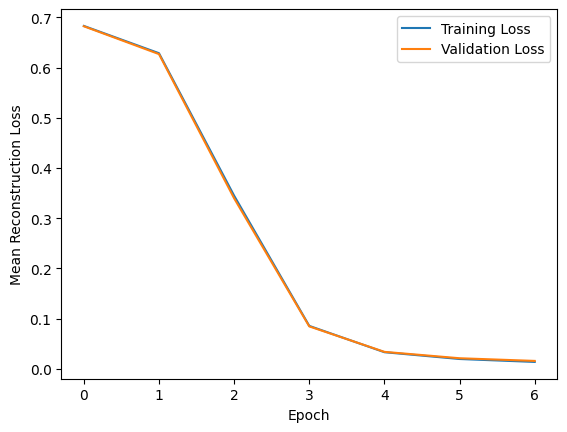

In [13]:
# Plot training and validation loss by epoch
fig, axs = plt.subplots()
axs.plot(per_epoch_loss_train, label="Training Loss")
axs.plot(per_epoch_loss_val, label="Validation Loss")
axs.set_xlabel("Epoch")
axs.set_ylabel("Mean Reconstruction Loss")
axs.legend()

In [14]:
val_prediction = dna_classifier.predict(seqs_val)
val_accuracy = np.mean(np.round(val_prediction) == labels_val)
print(f"Final accuracy on validation set: {val_accuracy}")

Final accuracy on validation set: 0.9968387776606955


I chose an architecture with three layers each with a decreasing dimension. This should hopefully distill increasingly important features from the DNA sequence deeper into the network, while still providing enough layers to learn complex features. I used a relu activation on all layers except the last, where the sigmoid is necessary as this is a binary prediction problem.

As this is a binary classification problem, I used the binary cross entropy loss function and a sigmoid activation in the final layer so answers would scale between 0 and 1.

I copied the training parameters from the digit autoencoder as an initial guess, and they performed very well so were not modified. The model shows a very steep loss during initial training followed by a short plateau at the end of the epochs, which indicates the model is learning without overfitting. The low validation loss and high accuracy on the validation set supports this belief.